In [19]:
using Pkg
Pkg.instantiate()

In [20]:
using Revise, CairoMakie
using ColonyImages
using DataFrames, CSV, FileIO, Dates, Serialization
import ColorSchemes as co 

In [21]:
df = DataFrame(data_set =String[], colony = String[], time = Int[], 
    metric_OG =Vector{Vector{Int64}}(undef,0), metric_cov = Vector{Vector{Int64}}(undef,0),
    pair_OG =Vector{Vector{Int64}}(undef,0),pair_cov =Vector{Vector{Int64}}(undef,0),OG_size = Int[])

Row,data_set,colony,time,metric_OG,metric_cov,pair_OG,pair_cov,OG_size
,String,String,Int64,Array…,Array…,Array…,Array…,Int64


In [22]:
para = parameters(
        im_size = [1600,1600],
        time_points = [0:2.0:48...],
        colony_nr = 10);

simulations = ["Random", "Finger_weak", "Finger_strong"]
plot_sim = false

In [ ]:
name_of_sim = "$(para.colony_nr)_col_$(length(simulations))_grow_type_2"
fig_path = joinpath("data", "artificial",name_of_sim)
path_metric = joinpath("data", "metrics")
mkpath(path_metric)
mkpath(fig_path)

"data\\artificial\\20_col_3_grow_type_2"

## Create empty datastructure for colony images

In [ ]:
pixel_to_add_vec = Int[];
vec_of_sims = Vector{Vector{BitArray{3}}}(undef, 0)
for i in 1:length(simulations)
    img_int_vec_1 = Vector{BitArray{3}}(undef, 0)
    for i in 1:para.colony_nr
        hans =BitArray(zeros(Bool, para.im_size...,para.stacks))
        push!(img_int_vec_1, hans)
    end
    push!(vec_of_sims, img_int_vec_1)
end

In [ ]:
pixel_to_add_vec = Int[];
for (x,sim) in enumerate(simulations)
    for (i,colony) in enumerate(vec_of_sims[x])
        for (j,t) in enumerate(para.time_points)
            # use view to work on array directly 
            int_img  = @view colony[:,:,j]
            dir_vec = generate_dir_vec(para)
            if j == 1
                build_artifical_colony!(para.Center,int_img,para.radius_colony,para.Points)
                pixel_to_add_vec = para.pixel_to_add(int_img)
            else
                # for unkown reason views require [:] to make assignments 
                int_img[:] = colony[:,:,j-1]
                if sim == "Random"
                    expand_colony_radom_cov!(int_img,pixel_to_add_vec[j-1])
                elseif sim == "Finger_weak"
                    expand_colony_finger_radom_cov!(int_img,pixel_to_add_vec[j-1],dir_vec)
                elseif sim == "Finger_strong"
                    expand_colony_finger_radom_cov!(int_img,pixel_to_add_vec[j-1],dir_vec, still_spawn_rate= 0.0, dir_match_rate = 0.9995)
                end
            end
        end
    end   
end

### Plot first colony test wise to see if everything worked as intended

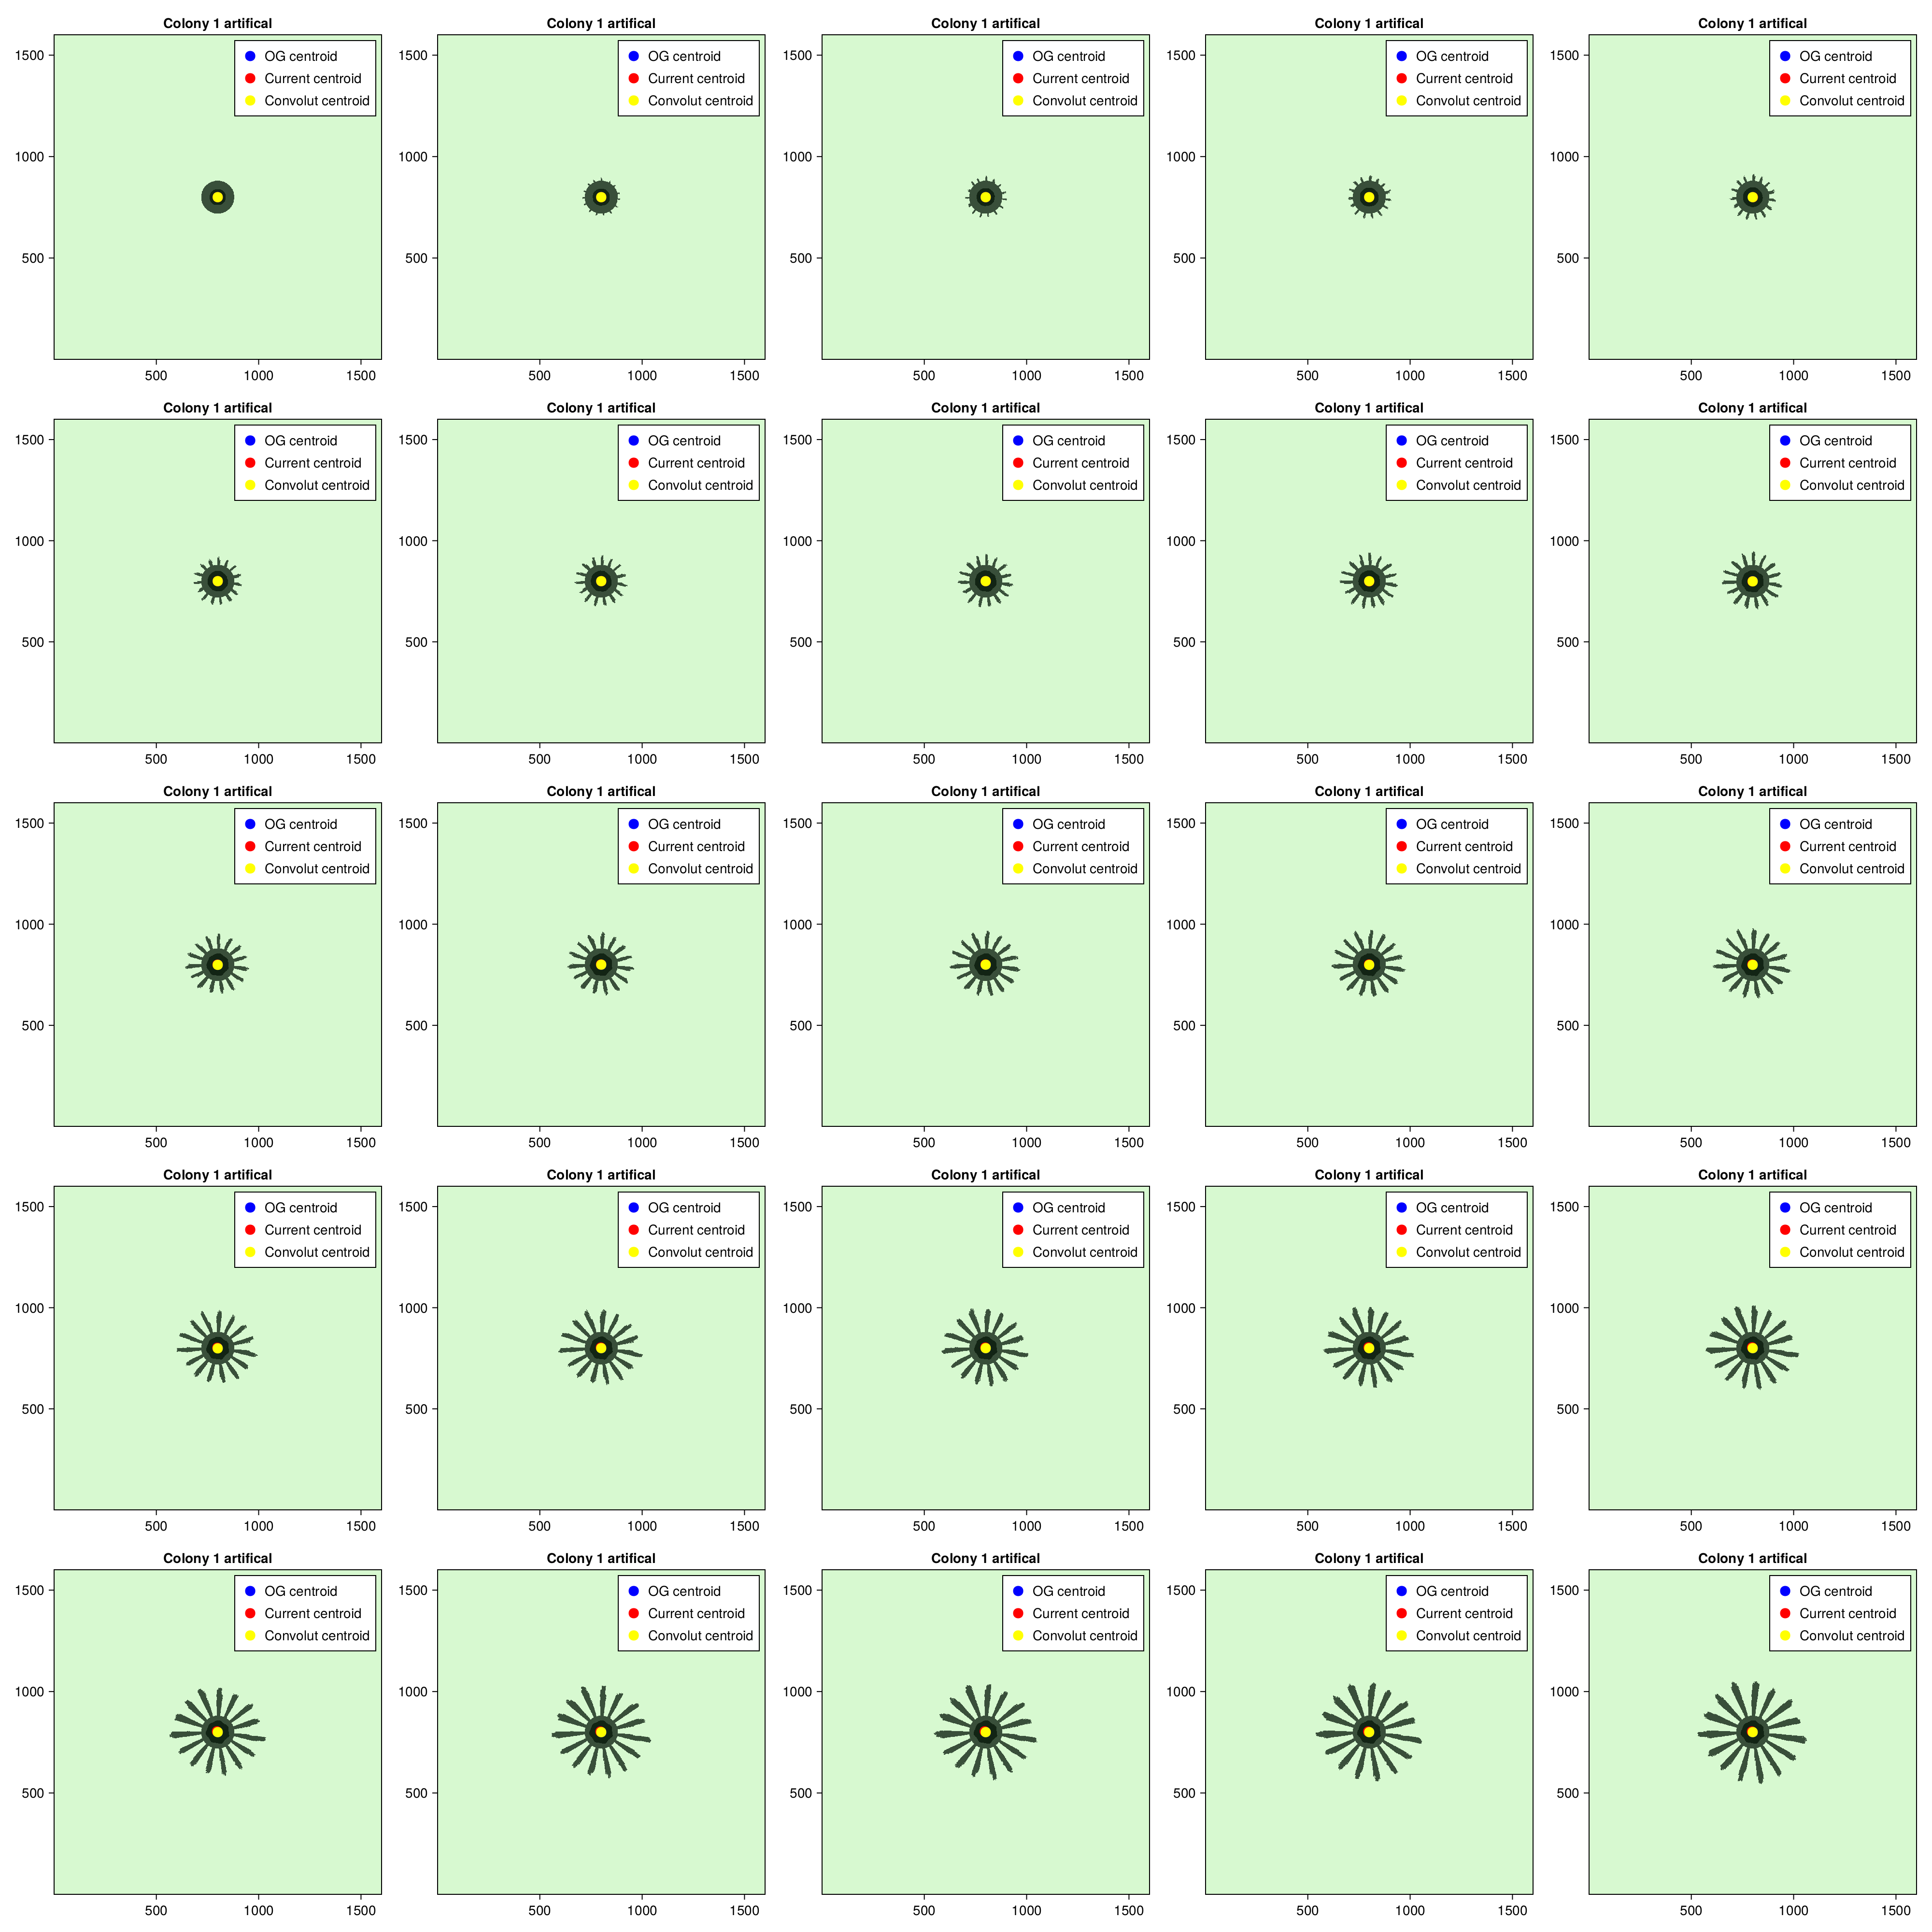

In [ ]:
fig_test = plot_time_series_cov_centroid(vec_of_sims[3][1:1], para)

###  Either plot sim into artifical data folder or not to save computation time

In [ ]:
if plot_sim 
    for (i,name) in enumerate(simulations)
        fig, data_set_name = plot_and_save_time_series_metrics!(vec_of_sims[i], para,df, name_data = name)
        save(joinpath(fig_path, data_set_name)*".png", fig)
    end
else
    for (i,name) in enumerate(simulations)
        data_set_name = save_time_series_metrics!(vec_of_sims[i], para,df, name_data = name)
    end
end

In [ ]:
first(df,2)

Row,data_set,colony,time,metric_OG,metric_cov,pair_OG,pair_cov,OG_size
,String,String,Int64,Array…,Array…,Array…,Array…,Int64
1,Random 2023_12_20,Colony 1 artifical,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0 … 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[63, 46, 59, 53, 58, 57, 57, 58, 56, 62 … 53, 62, 56, 58, 57, 57, 58, 53, 59, 63]","[5333, 5471, 5465, 5494, 5627, 5688, 5527, 5623, 5609, 5557 … 5450, 5595, 5612, 5599, 5489, 5624, 5571, 5566, 5500, 5460]","[5482, 5689, 5540, 5428, 5588, 5533, 5405, 5557, 5548, 5672 … 5509, 5778, 5706, 5577, 5498, 5489, 5664, 5475, 5643, 5572]",20589
2,Random 2023_12_20,Colony 1 artifical,2,"[4, 3, 1, 3, 1, 3, 3, 2, 3, 9 … 2, 1, 3, 2, 3, 5, 6, 6, 2, 4]","[2, 1, 1, 0, 2, 1, 1, 0, 1, 7 … 1, 1, 1, 0, 1, 3, 3, 3, 0, 2]","[4712, 6938, 5217, 5183, 5761, 5770, 5356, 4873, 6019, 5613 … 5810, 5925, 4959, 5359, 5842, 5683, 5156, 5248, 6349, 5178]","[5186, 7844, 5853, 5147, 5748, 5612, 5817, 4841, 5866, 6497 … 5785, 5583, 4624, 5869, 5237, 5964, 4752, 5402, 5883, 4981]",20589


In [ ]:
serialize(joinpath(path_metric,"$(name_of_sim*Dates.format(now(), "yyyy_mm_dd")).jls"),df)
CSV.write(joinpath(path_metric,"$(name_of_sim*Dates.format(now(), "yyyy_mm_dd")).csv"),df)

"data\\metrics\\20_col_3_grow_type_22023_12_20.csv"